In [84]:
import thermofun as fun # thermo. properties at T,P
import reaktoro as rkt # Gibbs free energy minimization
import numpy as np # math 
import matplotlib.pyplot as plt # plotting
import random # randomization

## 2. Initialize a thermodynamic database

In [2]:
database = fun.Database('./databases/Willy_ThermoFun_db.json')
database.appendData('./databases/elements.json') # append element data & data for H2O(l), OH-, and H+ to database
database.appendData('./databases/Willy_ThermoFun_db.json') # append data for Cu and Co species with correct units
database.appendData('./databases/Co_complexes.json') # append data for Co complexes
database.appendData('./databases/fO2_buffers.json') 

### 2a. Check the contents of the database (optional)

In [3]:
substances = database.mapSubstances()
# print(substances.keys())

## 3. Define and construct the chemical system

### 3a. Define and construct the main system

In [4]:
# Define the chemical system
editor = rkt.ChemicalEditor(database)
aqueousphase = editor.addAqueousPhaseWithElements([
    'H', 'O', 'Cl', 'Na', 'S', 'Co', 'Cu'])
aqueousphase.setChemicalModelDebyeHuckel()
editor.addGaseousPhase([
    'O2,rg', 'H2O,rg'])
editor.addMineralPhase([
    'Co-pentlandite', 'Chalcocite'])

# Construct the chemical system
system = rkt.ChemicalSystem(editor)

### 3b. Partition the main chemical system in order to fix $fO_2$ according to the $fO_2$ buffer reaction

In [5]:
partition = rkt.Partition(system)
partition.setInertSpecies(['O2,rg'])

### 3c. Define the $fO_2$ buffer reaction
$$2NiO_{(s)} \leftrightarrow 2Ni_{(s)} + O_{2(g)}$$
$$K = fO_2$$
$$logK = logfO_2$$
$$fO_2 = 10^{logK}$$

In [6]:
# initialize ThermoFun engine for calculation of fO2 buffer reaction properties
engine = fun.ThermoEngine(database)
# define fO2 buffer reaction
fO2_buffer_rxn = "2Bsn = 2Nickel + O2,rg"

## 4. Set temperature and pressure conditions

In [7]:
temperature = np.linspace(150,325,num=50) + 273.15 # [K]

# set saturated water vapor pressure
pressure = np.zeros(len(temperature))
for i,T in enumerate(temperature):
    pressure[i] = rkt.waterSaturatedPressureWagnerPruss(T).val/100000 # [bar] 

## 5. Set pH and chlorinity conditions

In [40]:
pH = 2
# chlorinity
amount_Cl = 0.5 # [molal]

## 6. Define the equilibrium problem

In [41]:
problems = []
for T,P in zip(temperature,pressure): 
    # define main equilibrium problem
    problem = rkt.EquilibriumProblem(system)
    
    # set extensive properties of system
    amount_H2O = 0.015 # [kg]
    problem.add("H2O",amount_H2O,"kg")
    problem.add("HCl",(10**-pH)*amount_H2O,"mol")
    problem.add("NaCl",(amount_Cl - (10**-pH))*amount_H2O,"mol")
    problem.add("CuCo2S4",0.1,"g") # 0.00007,"mol"
    
    ## add O2 according to logK calculated for fO2 buffer rxn
    rxn_properties = engine.thermoPropertiesReaction(T, P, fO2_buffer_rxn) 
    logK = rxn_properties.log_equilibrium_constant
    amount_O2 = (10**logK.val)*250/(8.314E-2*298.15) # [mol] assume fO2 = K, 250 mL autoclave vol., 25 °C, ideal gas
    problem.add("O2,rg",amount_O2,"mol")
    
    # set intensive properties of system
    problem.setTemperature(T,"kelvin")
    problem.setPressure(P,"bar")
    
    problems.append(problem) # append the new problem onto problems

## 7. Solve equilibrium states

### 7a. Set some model parameters

In [42]:
# set minimum value for equilibrium calculation
options = rkt.EquilibriumOptions()
options.optimum.output.active = True
options.epsilon = 1e-20

### 7b. Solve!

In [43]:
solver = rkt.EquilibriumSolver(system)
states = [rkt.ChemicalState(system) for _ in range(len(problems))]
solver.setOptions(options)
for i in range(len(problems)): 
    solver.solve(states[i], problems[i])

## 8. Get species with elements of interest

### 8a. Define a function to get species

In [44]:
def get_species_w_elements(elements): 
    matrix = system.formulaMatrix()
    species_names = []
    for j in range(len(elements)):
        species_names_list = []
        for i in range(len(matrix[system.indexElement(elements[j])])): 
            if matrix[system.indexElement(elements[j])][i] == 1:
                species_names_list.append(system.species(i).name())
        species_names.append(species_names_list)
    return species_names

### 8b. Get species

In [45]:
species_names = get_species_w_elements(["Cu", "Co"])
print(species_names)

[['Cu(HS)2-', 'Cu(OH)2-', 'Cu+', 'Cu++', 'CuCl', 'CuCl+', 'CuCl2', 'CuCl2-', 'CuCl3-', 'CuCl3--', 'CuCl4--', 'CuHS', 'CuO', 'CuO2--', 'CuOH', 'CuOH+', 'HCuO2-'], ['Co++', 'Co+++', 'CoCl+', 'CoCl2@', 'CoCl3-', 'CoCl4-2', 'CoH2S+2', 'CoHS+', 'CoO', 'CoO2--', 'CoOH+', 'CoOH++', 'HCoO2-']]


## 9. Get equilibrium amounts of above species 

### 9a. Define a function to get amounts of species

In [46]:
def get_species_amounts(species_names): 
    species_amounts = []
    for j in range(len(species_names)): 
        species_amount = []
        for i in range(len(species_names[j])): 
            species_amount.append([state.speciesAmount(species_names[j][i]) for state in states])
        species_amounts.append(species_amount)
    return species_amounts

### 9b. Get species amounts

In [47]:
species_amounts = get_species_amounts(species_names)

### 9c. Convert to relative species amounts

In [48]:
def get_rel_species_amounts(species_amounts):
    rel_species_amounts = species_amounts
    total_mol = [[0 for jj in range(len(species_amounts[ii][0]))] for ii in range(len(species_amounts))]
    for i in range(len(species_amounts)): # loop through elements
        for j in range(len(species_amounts[i][0])): # loop states
            for k in range(len(species_amounts[i])): # loop species
                total_mol[i][j] = total_mol[i][j] + species_amounts[i][k][j]
            for m in range(len(species_amounts[i])):
                rel_species_amounts[i][m][j] = species_amounts[i][m][j]/total_mol[i][j]

    return rel_species_amounts, total_mol

### 9d. Get relative species amounts

In [49]:
rel_species_amounts, total_mol = get_rel_species_amounts(species_amounts)

## 9. Plot the results

### 9a. Define function for plotting a custom figure

In [50]:
def custom_figure(x, y, fig, ax, legend_items=None, 
                  y_label=None, title=None, colors=None, plot_kwargs={}, legend_kwargs={}): 
    
    # set figure size
    fig.set_figheight(8)
    fig.set_figwidth(12)
    
    # set curve colors
    ax.set_prop_cycle('color', colors)
    
    # set background color
    ax.set_facecolor('w')
    
    # plot each curve
    ax.plot(x, np.transpose(y), **plot_kwargs)
    
    # define and place the legend
    ax.legend(legend_items, bbox_to_anchor=(1.04,1), loc="upper left", prop={"size":15}, **legend_kwargs)
    
    # set axes labels and title
    ax.set_xlabel('temperature (°C)')  
    ax.set_ylabel(y_label)  
    ax.set_title(title)   

### 9b. Plot Cu species

In [51]:
# set colors copied from [Colorgorical](http://vrl.cs.brown.edu/color)
colors0 = ["#a0e3b7", "#1c5872", "#37d356", "#860967", "#1aa7ee", "#473c85", 
            "#8fba06", "#6314af", "#fd92fa", "#1d6d1f", "#f7393a", "#fbd127", 
            "#873c1a", "#ffb4a2", "#464a15", "#d6bcf5", "#627de3"]
# shuffle color order
random.shuffle(colors0)

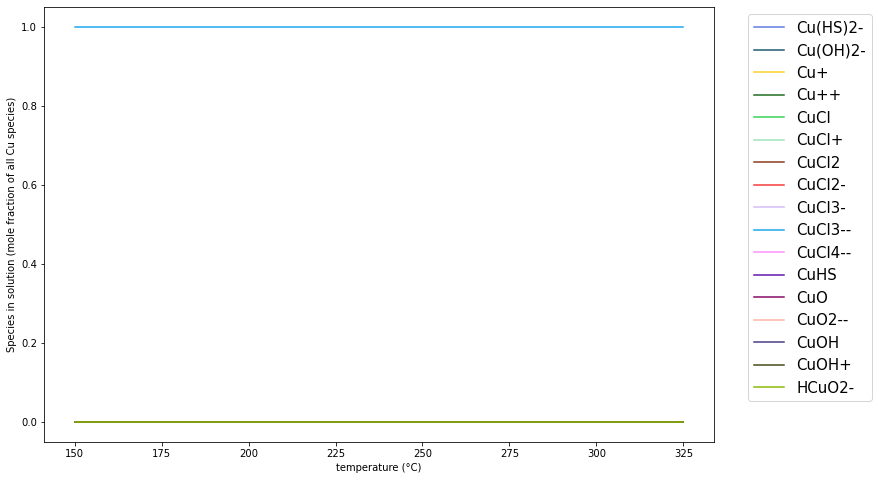

In [52]:
# set figure and axes
fig0, ax0 = plt.subplots()

# plot data
custom_figure(temperature-273.15, rel_species_amounts[0], fig0, ax0, 
              legend_items=species_names[0],
              colors=colors0,
              y_label='Species in solution (mole fraction of all Cu species)')


### 9c. Plot Co species

In [53]:
# set colors copied from [Colorgorical](http://vrl.cs.brown.edu/color)
colors1 = ["#41bbc5", "#422fae", "#a5d65a", "#b12060", "#42f18f", "#275b52", "#d5d2e7", 
           "#2c457d", "#faafe3", "#658114", "#fb5de7", "#51f310", "#d11f0b"]
# shuffle color order
random.shuffle(colors1)

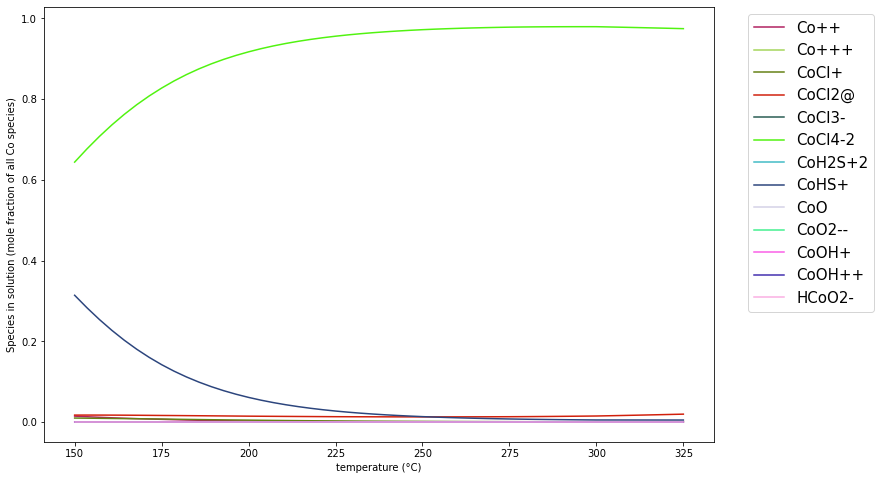

In [54]:
# set figure and axes
fig1, ax1 = plt.subplots()

# plot data
custom_figure(temperature-273.15, species_amounts[1], fig1, ax1, 
              legend_items=species_names[1],
              colors=colors1,
              y_label='Species in solution (mole fraction of all Co species)')


## 10. Retrieve and plot ionic strength

In [55]:
def get_ionic_strength(): 
    ionic_strength = np.zeros(len(temperature))
    for i,state in enumerate(states):
        properties = state.properties()
        ionic_strength_function = rkt.ChemicalProperty.ionicStrength(system)
        ionic_strength[i] = ionic_strength_function(properties).val
    return ionic_strength

In [56]:
ionic_strength = get_ionic_strength()

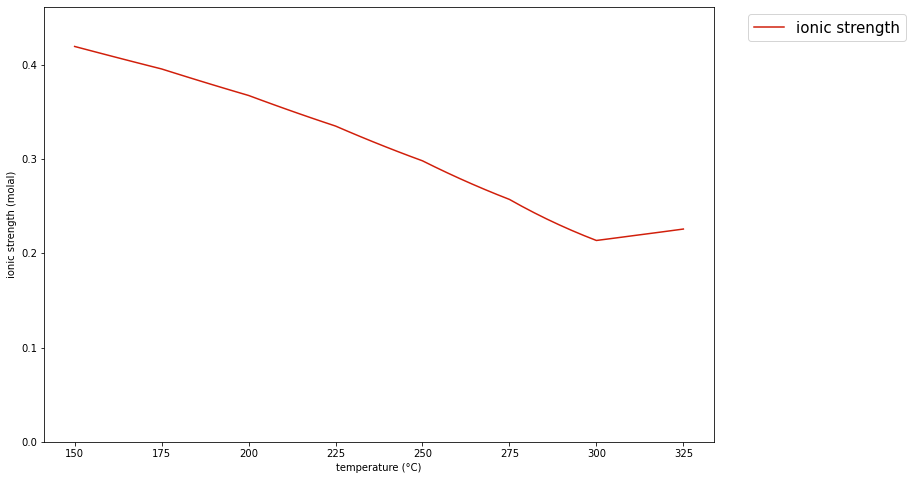

In [57]:
# set figure and axes
fig2, ax2 = plt.subplots()
ax2.set_ylim([0,1.1*max(ionic_strength)])
# plot data
custom_figure(temperature-273.15, ionic_strength, fig2, ax2, 
              legend_items=["ionic strength"],
              colors=colors1[3],
              y_label='ionic strength (molal)')

## 10. Plot total Cu and Co in solution

Text(0.5, 1.0, 'Total Cu and Co in solution')

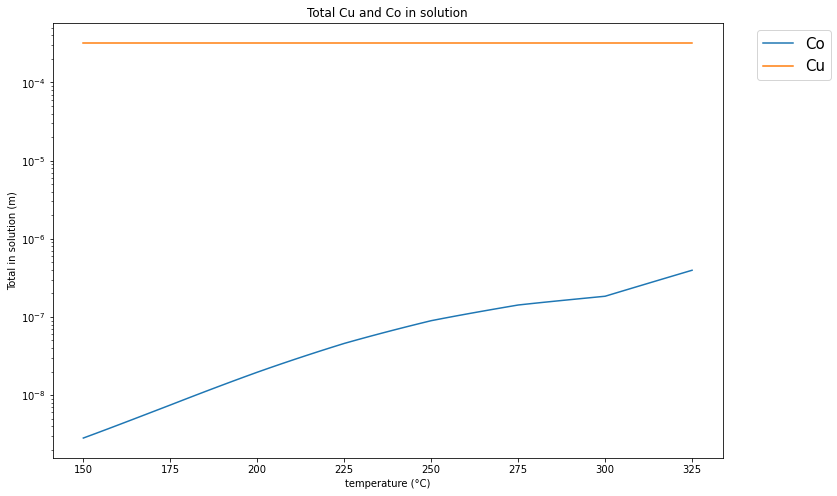

In [59]:
# set figure and axes
fig3, ax3 = plt.subplots(figsize=[12,8])


# plot data
ax3.semilogy(temperature-273.15, total_mol[1])
ax3.semilogy(temperature-273.15, total_mol[0])

# define and place the legend
ax3.legend(['Co','Cu'], bbox_to_anchor=(1.04,1), loc="upper left", prop={"size":15})


# set axes labels and title
ax3.set_xlabel('temperature (°C)')  
ax3.set_ylabel('Total in solution (m)')  
ax3.set_title('Total Cu and Co in solution')   

## 11. For reference, Ni-NiO logK

Text(0.5, 0, 'temperature (°C)')

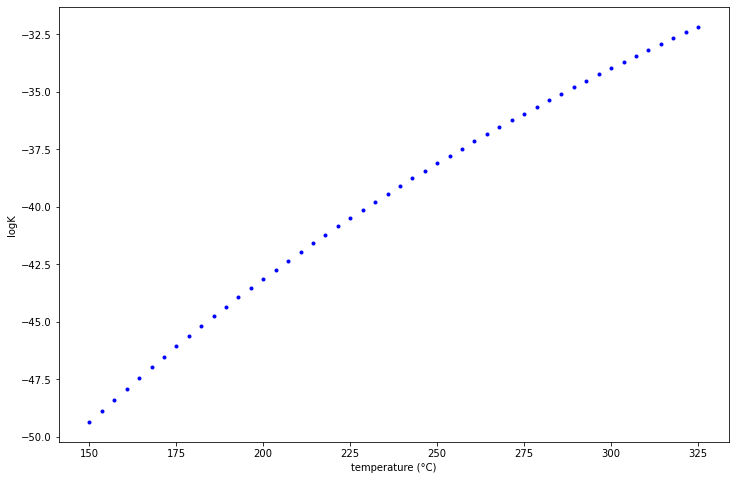

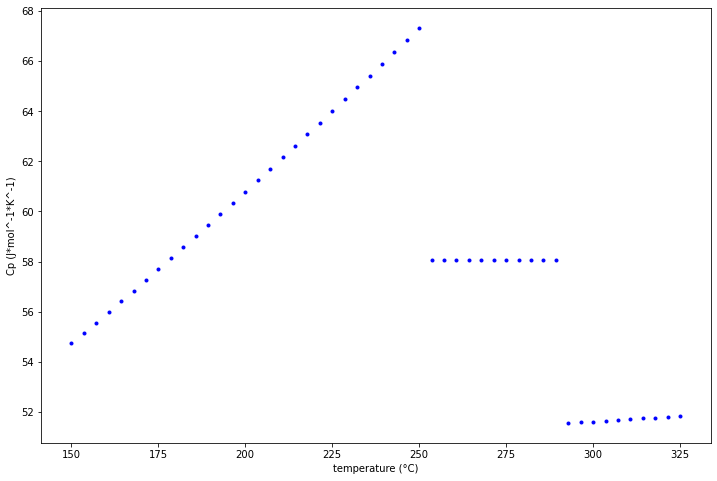

In [83]:
# set figure and axes
fig4, ax4 = plt.subplots(figsize=[12,8])
fig5, ax5 = plt.subplots(figsize=[12,8])
for T,P in zip(temperature,pressure):
    rxn_properties = engine.thermoPropertiesReaction(T, P, fO2_buffer_rxn) # 2Bsn = 2Nickel + O2,rg
    logK = rxn_properties.log_equilibrium_constant

    ax4.plot(T-273.15,logK.val,'.',color='blue')
    
    bunsenite_properties = engine.thermoPropertiesSubstance(T,P,'Bsn')
    Cp = bunsenite_properties.heat_capacity_cp
    ax5.plot(T-273.15,Cp.val,'.',color='blue')
    
ax4.set_ylabel('logK')
ax4.set_xlabel('temperature (°C)')

ax5.set_ylabel('Cp (J*mol^-1*K^-1)')
ax5.set_xlabel('temperature (°C)')